In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# load dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
data = pd.read_csv(file_path)

# metadata
metadata_columns = ['sex', 'age', 'education', 'IQ']

# condition columns
condition_columns = ['main.disorder', 'specific.disorder']

# time-series columns
time_series_columns = [col for col in data.columns if col.startswith('AB.') or col.startswith('COH.')]

# preprocess conditions
ohe = OneHotEncoder(sparse_output=False)
condition_matrix = ohe.fit_transform(data[condition_columns])

# normalize time-series data
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(data[time_series_columns])

# reshape time-series data
seq_length = len(time_series_columns)
time_series_data = time_series_data.reshape(-1, seq_length, 1)

# split data
X_train, X_test, y_train, y_test = train_test_split(time_series_data, condition_matrix, test_size=0.2, random_state=42)

# convert to PyTorch Tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# normalize input data for Time-Series
def normalize_time_series(data):
    """
    Normalize 3D time-series data (samples, timesteps, features).
    Flattens, scales, and reshapes the data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    num_samples, timesteps, features = data.shape

    # flatten to 2D: (samples * timesteps, features)
    data_2d = data.reshape(-1, features)

    # scale
    data_scaled = scaler.fit_transform(data_2d)

    # reshape back to 3D
    data_3d = data_scaled.reshape(num_samples, timesteps, features)
    return data_3d, scaler

# normalize train and test data
X_train_normalized, scaler = normalize_time_series(X_train)
X_test_normalized, _ = normalize_time_series(X_test)

# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


Epoch 1, Loss: 0.1294
Epoch 2, Loss: 0.0724
Epoch 3, Loss: 0.0697
Epoch 4, Loss: 0.0679
Epoch 5, Loss: 0.0676
Epoch 6, Loss: 0.0673
Epoch 7, Loss: 0.0671
Epoch 8, Loss: 0.0669
Epoch 9, Loss: 0.0670
Epoch 10, Loss: 0.0672
Epoch 11, Loss: 0.0669
Epoch 12, Loss: 0.0669
Epoch 13, Loss: 0.0669
Epoch 14, Loss: 0.0672
Epoch 15, Loss: 0.0670
Epoch 16, Loss: 0.0668
Epoch 17, Loss: 0.0670
Epoch 18, Loss: 0.0669
Epoch 19, Loss: 0.0669
Epoch 20, Loss: 0.0668
Epoch 21, Loss: 0.0668
Epoch 22, Loss: 0.0668
Epoch 23, Loss: 0.0667
Epoch 24, Loss: 0.0669
Epoch 25, Loss: 0.0667
Epoch 26, Loss: 0.0668
Epoch 27, Loss: 0.0670
Epoch 28, Loss: 0.0670
Epoch 29, Loss: 0.0669
Epoch 30, Loss: 0.0667
Epoch 31, Loss: 0.0667
Epoch 32, Loss: 0.0666
Epoch 33, Loss: 0.0665
Epoch 34, Loss: 0.0666
Epoch 35, Loss: 0.0667
Epoch 36, Loss: 0.0666
Epoch 37, Loss: 0.0666
Epoch 38, Loss: 0.0667
Epoch 39, Loss: 0.0666
Epoch 40, Loss: 0.0665
Epoch 41, Loss: 0.0665
Epoch 42, Loss: 0.0665
Epoch 43, Loss: 0.0666
Epoch 44, Loss: 0.06

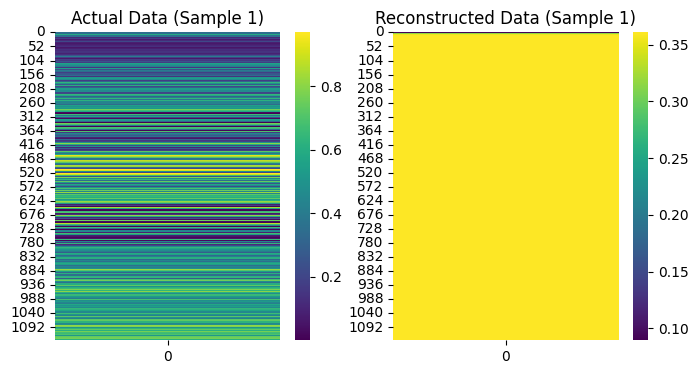

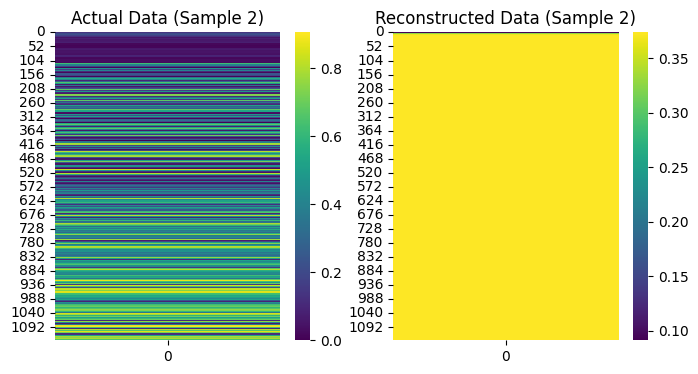

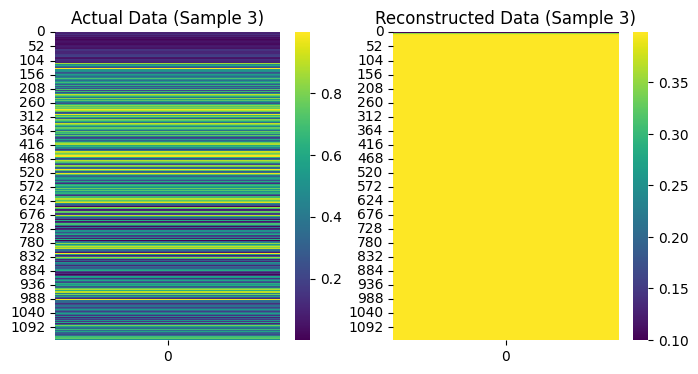

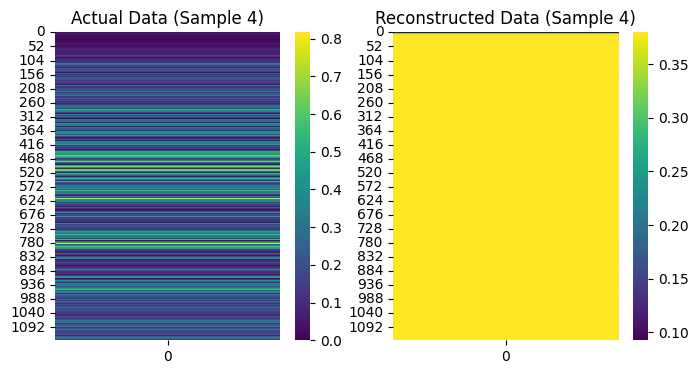

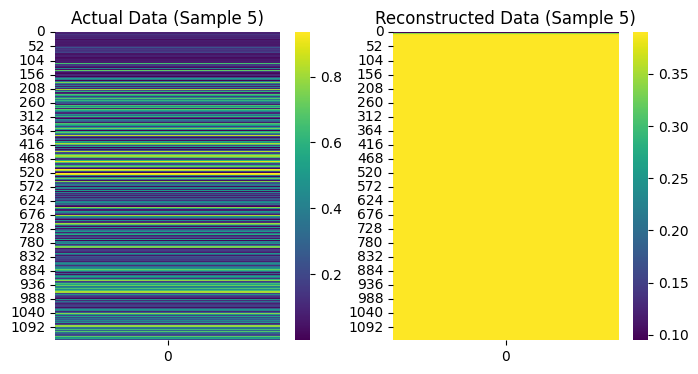

In [ ]:
# define the updated CVAE Model
class TimeSeriesCVAE(nn.Module):
    def __init__(self, seq_length, condition_dim, latent_dim):
        super(TimeSeriesCVAE, self).__init__()
        self.hidden_size = 128  # increased hidden size

        # encoder
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.fc_mu = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_size + condition_dim, latent_dim)

        # decoder
        self.decoder_lstm = nn.LSTM(input_size=latent_dim + condition_dim, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.decoder_output = nn.Linear(self.hidden_size, 1)

    def encode(self, x, c):
        _, (h, _) = self.encoder_lstm(x)
        h = h[-1]  # take the last hidden state
        h = torch.cat([h, c], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)
        c = c.unsqueeze(1).repeat(1, seq_length, 1)
        zc = torch.cat([z, c], dim=2)
        output, _ = self.decoder_lstm(zc)
        return self.decoder_output(output)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, x.size(1)), mu, logvar

# loss function
def cvae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_divergence

# train the updated CVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_length = X_train_tensor.shape[1]
condition_dim = y_train_tensor.shape[1]
latent_dim = 16

cvae = TimeSeriesCVAE(seq_length, condition_dim, latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device) # add channel dimension
        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)
        loss = cvae_loss(recon_x, x, mu, logvar, beta=0.1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader):.4f}")

print("Training complete.")

# visualize actual vs reconstructed data as heatmaps
def visualize_actual_vs_reconstructed(model, data_loader, num_samples=5):
    model.eval()
    actual_data = []
    reconstructed_data = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            recon_x, _, _ = model(x, c)
            actual_data.append(x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            if len(actual_data) >= num_samples:
                break

    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)


    print(actual_data.shape)
    print(reconstructed_data.shape)

    for i in range(num_samples):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        sns.heatmap(actual_data[i, :, :], cmap='viridis', cbar=True)
        plt.title(f"Actual Data (Sample {i+1})")
        plt.subplot(1, 2, 2)
        sns.heatmap(reconstructed_data[i, :, :], cmap='viridis', cbar=True)
        plt.title(f"Reconstructed Data (Sample {i+1})")
        plt.show()


# visualise reconstructions
visualize_actual_vs_reconstructed(cvae, test_loader, num_samples=5)

In [ ]:
def compute_dci(latent_vectors, labels):

    num_latent_dims = latent_vectors.shape[1]
    num_factors = labels.shape[1]

    importance_matrix = np.zeros((num_latent_dims, num_factors))
    informativeness_scores = []

    for i in range(num_factors):
        # train a logistic regression model for each factor
        factor_labels = labels[:, i]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_vectors, factor_labels)

        # record importance scores (coefficients)
        importance_matrix[:, i] = np.abs(model.coef_).mean(axis=0)

        # compute informativeness (accuracy)
        predictions = model.predict(latent_vectors)
        informativeness_scores.append(accuracy_score(factor_labels, predictions))

    # normalize importance matrix
    importance_matrix /= importance_matrix.sum(axis=0, keepdims=True)

    # disentanglement
    disentanglement_scores = 1.0 - importance_matrix.var(axis=1)
    disentanglement = disentanglement_scores.mean()

    # completeness
    completeness_scores = 1.0 - importance_matrix.var(axis=0)
    completeness = completeness_scores.mean()

    # informativeness
    informativeness = np.mean(informativeness_scores)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }

cvae.eval()
latent_vectors = []
labels = []

# extract latent representations and labels
with torch.no_grad():
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        mu, _ = cvae.encode(x, c)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(c.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# compute DCI metrics
dci_metrics = compute_dci(latent_vectors, labels)
print("DCI Metrics:", dci_metrics)


DCI Metrics: {'disentanglement': 0.9980786042184522, 'completeness': 0.9978003861102546, 'informativeness': 0.8947368421052632}


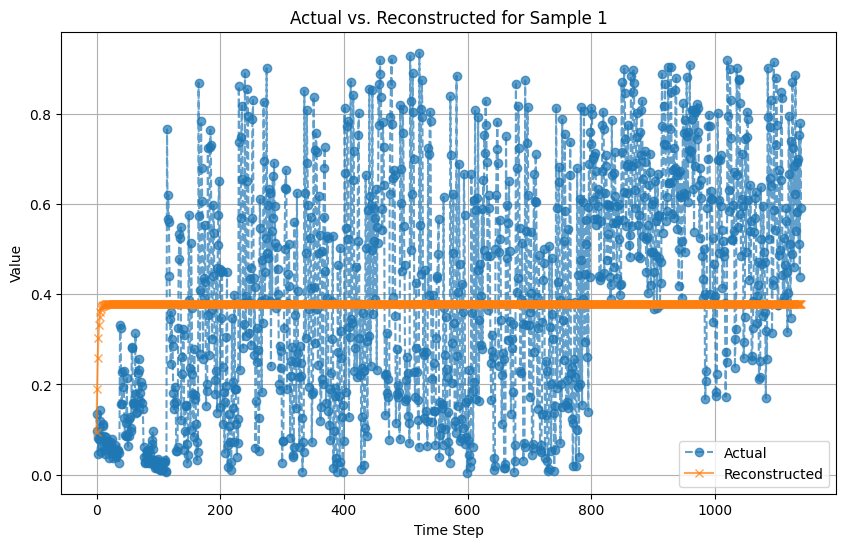

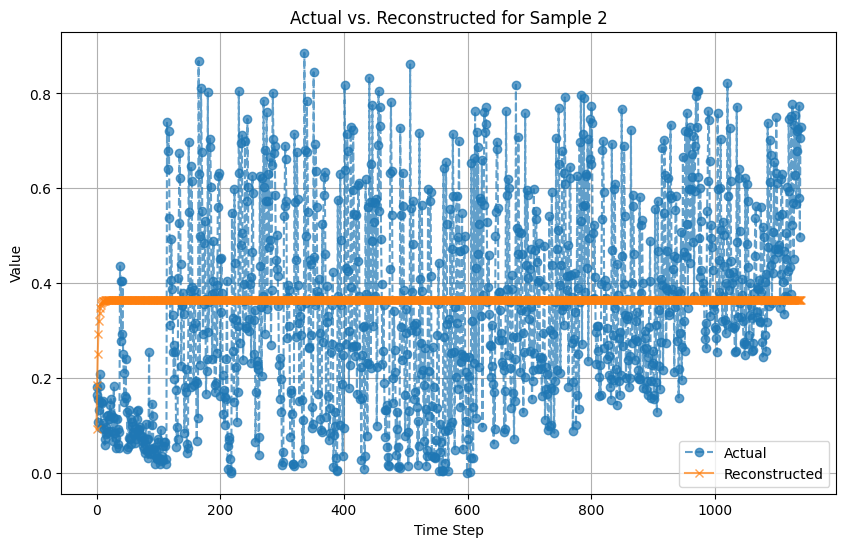

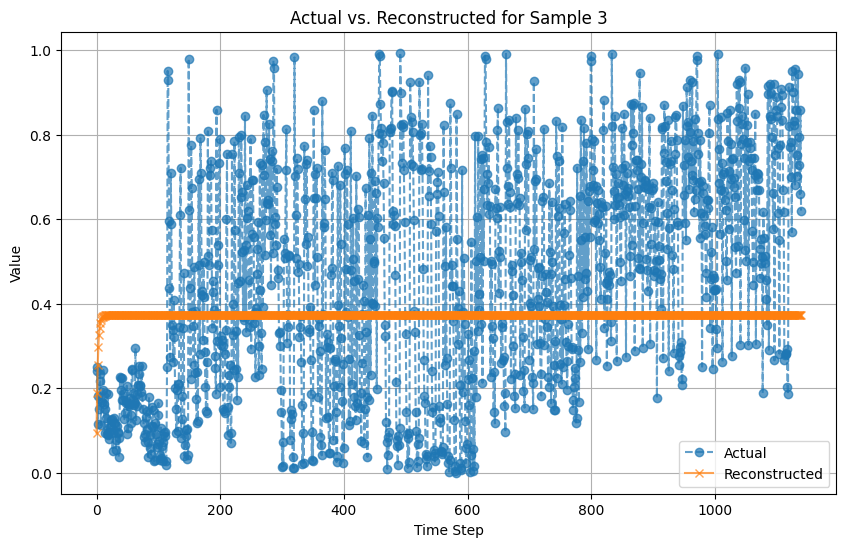

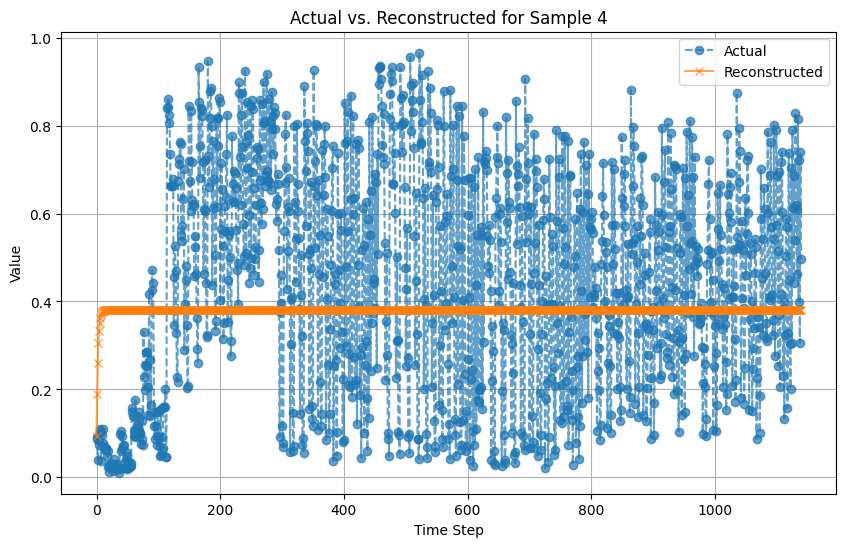

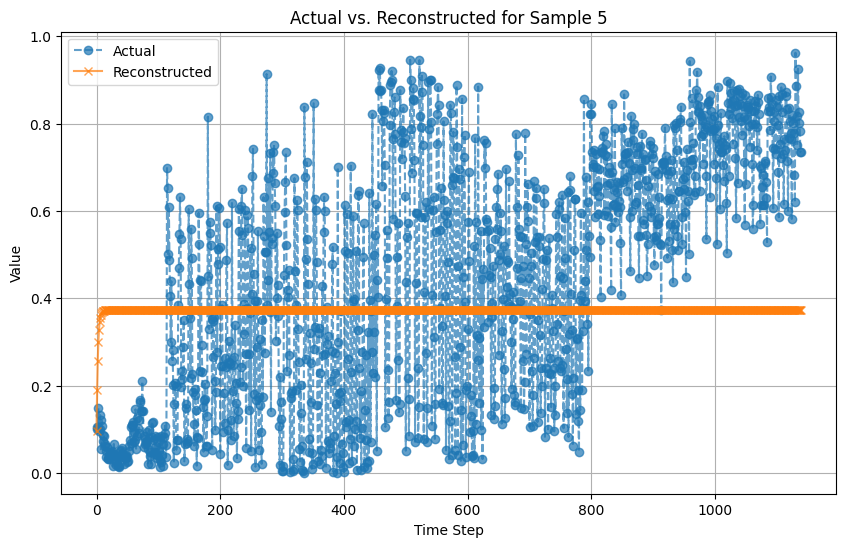

In [ ]:
def visualize_actual_vs_reconstructed(model, data_loader, condition_name, num_samples=5):

    model.eval()
    actual_data = []
    reconstructed_data = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)

            # find samples for the specific condition
            condition_mask = c[:, condition_name] == 1  # adjust for specific one-hot encoding index
            if condition_mask.sum() == 0:
                continue

            filtered_x = x[condition_mask]
            filtered_c = c[condition_mask]

            # reconstruct
            recon_x, _, _ = model(filtered_x, filtered_c)

            actual_data.append(filtered_x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            labels.append(filtered_c.cpu().numpy())

            # break if enough samples are collected
            if len(actual_data) >= num_samples:
                break

    # convert lists to arrays
    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)

    # plot actual vs reconstructed
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_data[i].squeeze(), label="Actual", linestyle="--", marker="o", alpha=0.7)
        plt.plot(reconstructed_data[i].squeeze(), label="Reconstructed", linestyle="-", marker="x", alpha=0.7)
        plt.title(f"Actual vs. Reconstructed for Sample {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()


condition_index = 0
visualize_actual_vs_reconstructed(cvae, test_loader, condition_name=condition_index, num_samples=5)


In [9]:
def extract_latent_space(model, data_loader):
    model.eval()
    latent_representations = []
    conditions = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            mu, logvar = model.encode(x, c)
            z = model.reparameterize(mu, logvar)
            latent_representations.append(z.cpu().numpy())
            conditions.append(c.cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)
    conditions = np.concatenate(conditions, axis=0)
    return latent_representations, conditions


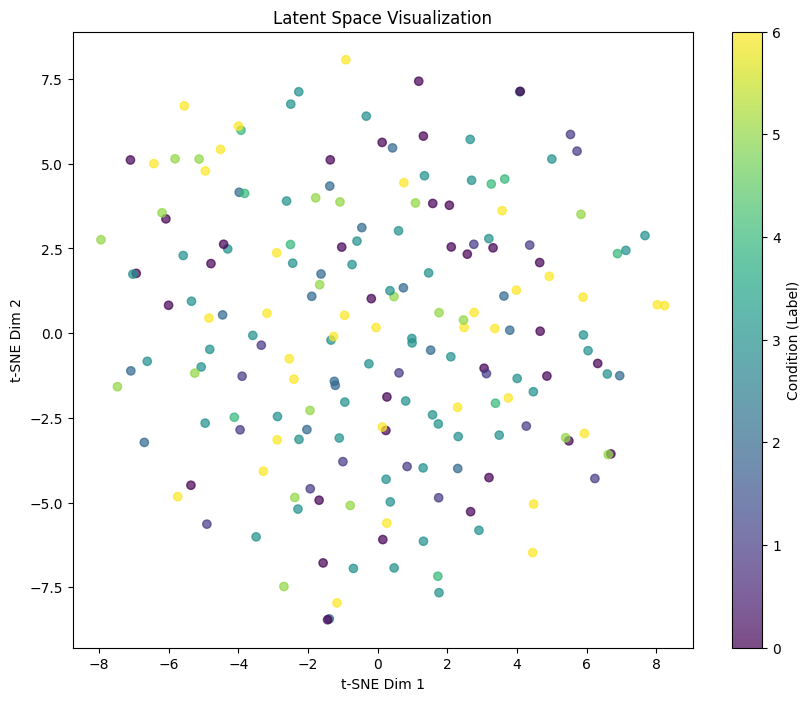

In [10]:
# extract latent space
latent_representations, conditions = extract_latent_space(cvae, test_loader)

# reduce dimensionality (to 2D for visualization)
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_representations)

# plot latent space with conditions
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.argmax(conditions, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(label="Condition (Label)")
plt.title("Latent Space Visualization")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


In [11]:
import plotly.express as px

fig = px.scatter(x=latent_2d[:, 0], y=latent_2d[:, 1],
                 color=np.argmax(conditions, axis=1),
                 title="Latent Space Visualization",
                 labels={"x": "t-SNE Dim 1", "y": "t-SNE Dim 2", "color": "Condition"})
fig.show()
